In [2]:
%matplotlib inline

In [3]:
import csv
import nltk
import itertools

In [4]:
import numpy as np
import theano as theano
import theano.tensor as T
import time
import operator
from utils import load_data, load_model_parameters_theano, generate_sentences, train_with_sgd
from gru_theano import *
import sys

In [5]:
import utils

In [6]:
SENTENCE_START_TOKEN = "SENTENCE_START"
SENTENCE_END_TOKEN = "SENTENCE_END"
UNKNOWN_TOKEN = "UNKNOWN_TOKEN"

In [10]:
def load_data(filename="data/reddit-comments-2015-08.csv", vocabulary_size=2000, min_sent_characters=0, train_split = 0):

    word_to_index = []
    index_to_word = []

    # Read the data and append SENTENCE_START and SENTENCE_END tokens
    print("Reading CSV file...")
    with open(filename, 'rt') as f:
        reader = csv.reader(f, skipinitialspace=True)
        reader.next()
        # Split full comments into sentences
        sentences = itertools.chain(*[nltk.sent_tokenize(x[0].decode("utf-8").lower()) for x in reader])
        # Filter sentences
        sentences = [s for s in sentences if len(s) >= min_sent_characters]
        sentences = [s for s in sentences if "http" not in s]
        # Append SENTENCE_START and SENTENCE_END
        sentences = ["%s %s %s" % (SENTENCE_START_TOKEN, x, SENTENCE_END_TOKEN) for x in sentences]
    print("Parsed %d sentences." % (len(sentences)))

    # Tokenize the sentences into words
    tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

    # Count the word frequencies
    word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    print("Found %d unique words tokens." % len(word_freq.items()))

    # Get the most common words and build index_to_word and word_to_index vectors
    vocab = sorted(word_freq.items(), key=lambda x: (x[1], x[0]), reverse=True)[:vocabulary_size-2]
    print("Using vocabulary size %d." % vocabulary_size)
    print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

    sorted_vocab = sorted(vocab, key=operator.itemgetter(1))
    index_to_word = ["<MASK/>", UNKNOWN_TOKEN] + [x[0] for x in sorted_vocab]
    word_to_index = dict([(w, i) for i, w in enumerate(index_to_word)])

    # Replace all words not in our vocabulary with the unknown token
    for i, sent in enumerate(tokenized_sentences):
        tokenized_sentences[i] = [w if w in word_to_index else UNKNOWN_TOKEN for w in sent]

    # Create the training data
    X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences[train_split:]])
    y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences[train_split:]])

    X_test = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences[:train_split]])
    Y_test = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences[:train_split]])

    return X_train, y_train, X_test, Y_test, word_to_index, index_to_word

In [12]:
# Load data (this may take a few minutes)
VOCABULARY_SIZE = 1400
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data('../onion_titles.csv', VOCABULARY_SIZE, train_split = 100)

Reading CSV file...
Parsed 286 sentences.
Found 1407 unique words tokens.
Using vocabulary size 1400.
The least frequent word in our vocabulary is '100' and appeared 1 times.


In [13]:
# Load data (this may take a few minutes)
VOCABULARY_SIZE = 8000
ny_X_train, ny_y_train,ny_X_test, ny_y_test, ny_word_to_index, ny_index_to_word = load_data('../nyt_headlines.csv', VOCABULARY_SIZE, train_split = 1000)

Reading CSV file...
Parsed 8719 sentences.
Found 14486 unique words tokens.
Using vocabulary size 8000.
The least frequent word in our vocabulary is 'sleeps' and appeared 1 times.


In [25]:
len(X_train)

186

In [7]:
# Load parameters of pre-trained model
model = load_model_parameters_theano('onion-train-gru.npz')

Building model model from onion-train-gru.npz with hidden_dim=128 word_dim=1400


/Users/brendan/.virtualenvs/practical1/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [8]:
# Load parameters of pre-trained model
nyt_model = load_model_parameters_theano('ny-train-gru.npz')

Building model model from ny-train-gru.npz with hidden_dim=128 word_dim=8000


In [26]:
#Build your own model (not recommended unless you have a lot of time!)

LEARNING_RATE = 1e-3
NEPOCH = 20
HIDDEN_DIM = 128

model = GRUTheano(VOCABULARY_SIZE, HIDDEN_DIM)

t1 = time.time()
model.sgd_step(X_train[0], y_train[0], LEARNING_RATE)
t2 = time.time()
print "SGD Step time: ~%f milliseconds" % ((t2 - t1) * 1000.)

train_with_sgd(model, X_train, y_train, LEARNING_RATE, NEPOCH, decay=0.9)

SGD Step time: ~102.545023 milliseconds


/Users/brendan/.virtualenvs/practical1/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


<gru_theano.GRUTheano instance at 0x10b3057e8>

In [32]:
#Build your own model (not recommended unless you have a lot of time!)

LEARNING_RATE = 1e-3
NEPOCH = 20
HIDDEN_DIM = 128

nyt_model = GRUTheano(VOCABULARY_SIZE, HIDDEN_DIM)

train_with_sgd(nyt_model, ny_X_train, ny_y_train, LEARNING_RATE, NEPOCH, decay=0.9)

KeyboardInterrupt: 

In [33]:
utils.save_model_parameters_theano(nyt_model, 'ny-train-gru.npz')

Saved model parameters to ny-train-gru.npz.


In [125]:
import itertools
import nltk

In [132]:
import csv
ny_list = []
with open('../nyt_headlines.csv', 'rb') as f:
    reader = csv.reader(f, skipinitialspace=True)
    ny_list = [x[0].decode("utf-8").lower() for x in reader]


In [133]:
first_two_words = [x.split()[:2] for x in ny_list]
first_three_words = [x.split()[:3] for x in ny_list]

In [28]:
def generate_sentence_2(model, index_to_word, word_to_index, first_n_words, min_length=5):
    # We start the sentence with the start token
    # Repeat until we get an end token
    new_sentence = [word_to_index[x] for x in first_n_words if x in word_to_index]
    old_new_sentence = list(new_sentence)
    if new_sentence == []:
        return None
    while not new_sentence[-1] == word_to_index[utils.SENTENCE_END_TOKEN]:
        next_word_probs = model.predict(new_sentence)[-1]
        samples = np.random.multinomial(1, next_word_probs)
        sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
        # Seomtimes we get stuck if the sentence becomes too long, e.g. "........" :(
        # And: We don't want sentences with UNKNOWN_TOKEN's
        if len(new_sentence) > 100 or sampled_word == word_to_index[utils.UNKNOWN_TOKEN]:
            return None
    if len(new_sentence) < min_length:
        return None
    return new_sentence

In [29]:
def generate_sentences_2(model, n, index_to_word, word_to_index, first_n_words):
    for i in range(n):
        sent = None
        sent = generate_sentence_2(model, index_to_word, word_to_index, first_n_words[i])
        if sent is not None:
            print ''.join(ny_list[i])
            utils.print_sentence(sent, index_to_word)

In [14]:
def prob_of_sentence(model, index_to_word, word_to_index, sentence, min_length=5):
    sentence = sentence.split()
    tokenized_sentence = []
    for x in sentence:
        if x in word_to_index:
            tokenized_sentence.append(word_to_index[x])
        else:
            tokenized_sentence.append(word_to_index[UNKNOWN_TOKEN])
    #print tokenized_sentence
    prob_arr = []
    for x in xrange(1,len(tokenized_sentence)):
        next_word_probs = model.predict(tokenized_sentence[:x])
        next_word_probs = next_word_probs[x - 1]
        prob_arr.append(next_word_probs[tokenized_sentence[x]])
    return prob_arr

In [28]:
for z in onion_titles[:100]:
    print prob_of_sentence(model, index_to_word, word_to_index, z)

[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.018593509515275219]
[0.0019388785387590263, 0.01859350

In [34]:
onion_titles

[]

In [45]:
feats = []
for z in onion_titles[:100]:
    x = prob_of_sentence(model, index_to_word, word_to_index, z)
    y = prob_of_sentence(nyt_model, ny_index_to_word, ny_word_to_index, z)
    feats.append([sum(x)/len(x), max(x), max(x[1:]), min(x), sum(y)/len(y), max(y), max(y[1:]), min(y), 0])
for z in nyt_titles[:1000]:
    x = prob_of_sentence(model, index_to_word, word_to_index, z)
    y = prob_of_sentence(nyt_model, ny_index_to_word, ny_word_to_index, z)
    feats.append([sum(x)/len(x), max(x), max(x[1:]), min(x), sum(y)/len(y), max(y), max(y[1:]), min(y), 1])

In [46]:
len(feats[10])

9

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
import random

In [49]:
def scrambled(orig):
    dest = orig[:]
    random.shuffle(dest)
    return dest

In [50]:
roc_gen = []
estimator = RandomForestClassifier(random_state=0, n_estimators=100)
scrambled_feats = scrambled(feats)
rf_model = estimator.fit([x[:-1] for x in scrambled_feats[500:]], [x[-1] for x in scrambled_feats[500:]])
for z in xrange(len(scrambled_feats[:500])):
    print [rf_model.predict_proba(scrambled_feats[z][:-1])[0][1], scrambled_feats[z][-1]]
    roc_gen.append([rf_model.predict_proba(scrambled_feats[z][:-1])[0][1], scrambled_feats[z][-1]])

[1.0, 1]
[1.0, 1]
[1.0, 1]
[0.87, 1]
[0.96999999999999997, 1]
[0.94999999999999996, 0]
[0.96999999999999997, 1]
[0.98999999999999999, 0]
[0.79000000000000004, 1]
[0.93000000000000005, 1]
[0.93999999999999995, 1]
[1.0, 1]
[0.54000000000000004, 0]
[0.81999999999999995, 1]
[1.0, 1]
[0.94999999999999996, 1]
[0.85999999999999999, 1]
[0.89000000000000001, 1]
[0.98999999999999999, 1]
[0.88, 1]
[0.89000000000000001, 1]
[1.0, 1]
[0.95999999999999996, 1]
[0.93999999999999995, 1]
[0.79000000000000004, 1]
[0.83999999999999997, 1]
[0.57999999999999996, 0]
[0.88, 0]
[1.0, 1]
[0.85999999999999999, 1]
[1.0, 1]
[0.93999999999999995, 1]
[0.42999999999999999, 0]
[0.96999999999999997, 1]
[0.98999999999999999, 1]
[0.97999999999999998, 1]
[1.0, 1]
[0.96999999999999997, 1]
[1.0, 1]
[1.0, 1]
[0.91000000000000003, 1]
[0.98999999999999999, 1]
[1.0, 1]
[0.76000000000000001, 0]
[0.95999999999999996, 1]
[1.0, 1]
[0.82999999999999996, 1]
[0.80000000000000004, 1]
[0.98999999999999999, 1]
[1.0, 1]
[0.9799999999999999

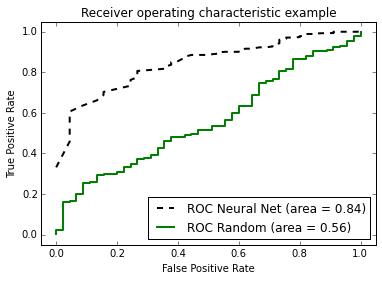

In [56]:
fpr, tpr, thresholds = roc_curve([x[1] for x in roc_gen], [x[0] for x in roc_gen])
ac = auc(fpr,tpr)
plt.plot(fpr, tpr, 'k--',
         label='ROC Neural Net (area = %0.2f)' % ac, lw=2)
fpr, tpr, thresholds = roc_curve([x[1] for x in roc_gen], [random.random() for x in roc_gen])
ac = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g',
         label='ROC Random (area = %0.2f)' % ac, lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [105]:
with open('../onion_features_fixed.csv', 'rb') as f:
    reader = csv.reader(f, skipinitialspace=True)
    # Split full comments into sentences
    onion_features = [x for x in reader]


In [115]:
with open('../ny_features_fixed.csv', 'rb') as f:
    reader = csv.reader(f, skipinitialspace=True)
    # Split full comments into sentences
    ny_features = [x for x in reader]

In [109]:
nyt_titles

[u"SENTENCE_START millsap's double-double leads hawks over grizzlies, 116-101 SENTENCE_END",
 u'SENTENCE_START u.s. citizens might be present at mali hotel: state department SENTENCE_END',
 u'SENTENCE_START china to restructure poorly performing state firms-assets supervisor SENTENCE_END',
 u'SENTENCE_START high-profile chinese investor xu xiang detained SENTENCE_END',
 u'SENTENCE_START molly mccormick and mark street: did someone play \u2018come fly with me\u2019? SENTENCE_END',
 u'SENTENCE_START &#8216;crescent to cross&#8217; by richard long is at sperone westwater SENTENCE_END',
 u'SENTENCE_START republican gov. SENTENCE_END',
 u'SENTENCE_START phil bryant wins second term in mississippi SENTENCE_END',
 u'SENTENCE_START illinois: attorney general seeks release of a police video  SENTENCE_END',
 u"SENTENCE_START egypt's military controlling repatriation of russian passengers: russian deputy pm SENTENCE_END",
 u'SENTENCE_START high school player dies SENTENCE_END',
 u"SENTENCE_START 

In [106]:
onion_features = [[int(z) for z in x[-5:]] for x in onion_features]

In [117]:
ny_features = [[int(z) for z in x[-5:]] for x in ny_features[:1000]]

/Users/brendan/.virtualenvs/practical1/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


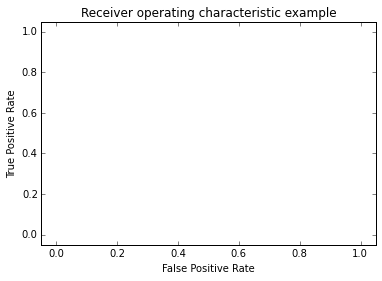

In [54]:
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(, probas_[:, 1])


In [52]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt


In [124]:
model.feature_importances_

array([ 0.0717663 ,  0.06315444,  0.04152402,  0.10389455,  0.53855331,
        0.05106746,  0.02561452,  0.02655923,  0.04140006,  0.0364661 ])

In [105]:
for z in nyt_titles[:10]:
    x = prob_of_sentence(model, index_to_word, word_to_index, z)
    print sum(x)/len(x), max(x[1:]), min(x), np.median(x)

0.00211581123388 0.00433622885335 0.00109283378319 0.00178326684113
0.00286961958426 0.0114616690415 0.000179201142805 0.00230672284316
0.00606412846706 0.0328095347971 0.000589342914421 0.00327828428248
0.00352601260978 0.0124076430846 0.00149636396008 0.00228503874672
0.0284065272514 0.342045606231 7.50642325577e-05 0.0018307165841
0.00906528748724 0.055566802833 0.000212420427459 0.00338016265006
0.00228048498932 0.00340621246912 0.00149636396008 0.00193887853876
0.00591963602168 0.0343777545898 0.00019070525185 0.00169634235405
0.00149704497697 0.00347616485796 0.000226880460102 0.0016895733794
0.00716621999944 0.0577916556899 0.000510402869503 0.00193887853876


In [102]:
from sklearn.ensemble import RandomForestRegressor

ImportError: No module named statistics

In [ ]:
min_sent_characters =0 
filename = '../onion_features.csv'
with open(filename, 'rt') as f:

    reader = csv.reader(f, skipinitialspace=True)
    reader.next()
    # Split full comments into sentences
    onion_features = [nltk.sent_tokenize(x[0].decode("utf-8").lower()) for x in reader]
    onion_titles = itertools.chain(*[nltk.sent_tokenize(x[0].decode("utf-8").lower()) for x in reader])
    # Filter sentences
    onion_titles = [s for s in onion_titles if len(s) >= min_sent_characters]
    onion_titles = [s for s in onion_titles if "http" not in s]
    # Append SENTENCE_START and SENTENCE_END
    onion_titles = ["%s %s %s" % (SENTENCE_START_TOKEN, x, SENTENCE_END_TOKEN) for x in onion_titles]
 

In [53]:
len(a[0])

1400

In [86]:
first_two_words[10]

u'd'

In [143]:
2+2

4

In [42]:
min_sent_characters =0 
filename = '../onion_titles.csv'
with open(filename, 'rt') as f:
    reader = csv.reader(f, skipinitialspace=True)
    reader.next()
    # Split full comments into sentences
    onion_titles = itertools.chain(*[nltk.sent_tokenize(x[0].decode("utf-8").lower()) for x in reader])
    # Filter sentences
    onion_titles = [s for s in onion_titles if len(s) >= min_sent_characters]
    onion_titles = [s for s in onion_titles if "http" not in s]
    # Append SENTENCE_START and SENTENCE_END
    onion_titles = ["%s %s %s" % (SENTENCE_START_TOKEN, x, SENTENCE_END_TOKEN) for x in onion_titles]
 

In [43]:
min_sent_characters =0 
filename = '../nyt_headlines.csv'
with open(filename, 'rt') as f:
    reader = csv.reader(f, skipinitialspace=True)
    reader.next()
    # Split full comments into sentences
    nyt_titles = itertools.chain(*[nltk.sent_tokenize(x[0].decode("utf-8").lower()) for x in reader])
    # Filter sentences
    nyt_titles = [s for s in nyt_titles if len(s) >= min_sent_characters]
    nyt_titles = [s for s in nyt_titles if "http" not in s]
    # Append SENTENCE_START and SENTENCE_END
    nyt_titles = ["%s %s %s" % (SENTENCE_START_TOKEN, x, SENTENCE_END_TOKEN) for x in nyt_titles]

In [44]:
onion_titles

[u'SENTENCE_START tips for traveling with young children SENTENCE_END',
 u'SENTENCE_START area family has no idea where dad gets shirts SENTENCE_END',
 u'SENTENCE_START area man uninterested in creating a better community even though this may benefit him in the long run SENTENCE_END',
 u'SENTENCE_START everything taking too long SENTENCE_END',
 u'SENTENCE_START mother still searching for preschool that focuses exclusively on her son SENTENCE_END',
 u'SENTENCE_START banjo player sought in hootenanny spree SENTENCE_END',
 u'SENTENCE_START hundreds of horrified onlookers gather around wreckage of area man SENTENCE_END',
 u'SENTENCE_START tips for a healthy pregnancy SENTENCE_END',
 u"SENTENCE_START area man does indeed belong at applebee's SENTENCE_END",
 u"SENTENCE_START man at bar clinging to muted 'king of queens' episode like life preserver SENTENCE_END",
 u'SENTENCE_START area man proud he can still fit into car from high school SENTENCE_END',
 u'SENTENCE_START 38-year-old little boy

In [72]:
[0,1][:1]

[0]